In [1]:
%matplotlib inline
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense, Activation, GlobalAveragePooling2D
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from PIL import Image

# Load the preprocessed data

In [2]:
def load_data():
    X_train_name = 'X_train.pickle'
    X_test_name = 'X_test.pickle'
    y_train_name = 'y_train.pickle'
    y_test_name = 'y_test.pickle'
    train_folder = '/home/olli/Projects/Exercises/Dogs_Cats/Train_Scaled'
    
    testdata_name = 'testdata.pickle'
    test_folder = '/home/olli/Projects/Exercises/Dogs_Cats/Test_Scaled'
    
    X_train_path = os.path.join(train_folder, X_train_name)
    X_test_path = os.path.join(train_folder, X_test_name)
    y_train_path = os.path.join(train_folder, y_train_name)
    y_test_path = os.path.join(train_folder, y_test_name)
    
    with open(X_train_path, 'rb') as f1:
        X_train = pickle.load(f1)
    with open(X_test_path, 'rb') as f2:
        X_test = pickle.load(f2)
    with open(y_train_path, 'rb') as f3:
        y_train = pickle.load(f3)
    with open(y_test_path, 'rb') as f4:
        y_test = pickle.load(f4)
        
    testdata_path = os.path.join(test_folder, testdata_name)
    
    with open(testdata_path, 'rb') as f5:
        testdata = pickle.load(f5)
        
    return X_train, X_test, y_train, y_test, testdata

In [3]:
X_train, X_test, y_train, y_test, testdata = load_data()

# Create a model & tune hyperparameters

In [4]:
def build_model_1(hp):
    
    num_conv_pool_layers = hp.Int('Add_Conv_Layers', 0, 2, 1)  # 0-2 additional conv & pooling layers
    
    features = Input(shape=X_train.shape[1:])
    
    x = Conv2D(filters=hp.Choice('1_Conv_Filter', [8, 16, 32, 64]), kernel_size=(3, 3))(features)
    x = MaxPool2D()(x)
    
    for add_layer in range(num_conv_pool_layers):
        x = Conv2D(filters=hp.Choice(f'{add_layer + 2}_Conv_Filter', [8, 16, 32, 64]), kernel_size=(3, 3))(x)
        x = MaxPool2D()(x)
    
    x = GlobalAveragePooling2D()(x)  # better then flatten (less but more usefull features)
    
    num_dense_layers = hp.Int('Add_Dense_Layers', 0, 2, 1)
    drop_rate = hp.Float('Drop_Rate', 0.1, 0.5, 0.1)
    
    x = Dense(hp.Choice('1_Dense_Units', [64, 128, 256, 512]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    for add_layer in range(num_dense_layers):
        x = Dense(hp.Choice(f'{add_layer + 2}_Dense_Units', [8, 16, 32, 64, 128, 256]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(drop_rate)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=features, outputs=output)
    
    LR = hp.Float('Learing_Rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
    
    return model    

In [5]:
tuner_1 = kt.RandomSearch(
    hypermodel=build_model_1,
    objective='val_loss',
    max_trials=120,
    directory='Logs_Tuner_1')

INFO:tensorflow:Reloading Oracle from existing project Logs_Tuner_1/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from Logs_Tuner_1/untitled_project/tuner0.json


2022-09-02 21:39:58.892760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 21:39:58.973011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 21:39:58.974179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 21:39:58.975563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
tuner_1.search(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

In [7]:
tuner_1.results_summary(1)

Results summary
Results in Logs_Tuner_1/untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Add_Conv_Layers: 2
1_Conv_Filter: 32
Add_Dense_Layers: 0
Drop_Rate: 0.2
1_Dense_Units: 64
Learing_Rate: 0.0030433427843111825
2_Conv_Filter: 64
3_Conv_Filter: 16
2_Dense_Units: 8
3_Dense_Units: 128
Score: 0.6069033145904541


In [8]:
def build_model_2(hp):
    
    features = Input(shape=X_train.shape[1:])
    
    x = Conv2D(filters=hp.Choice('1_Conv_Filter', [16, 32, 64]), kernel_size=(3, 3))(features)
    x = MaxPool2D()(x)
    x = Conv2D(filters=hp.Choice('2_Conv_Filter', [16, 32, 64]), kernel_size=(3, 3))(x)
    x = MaxPool2D()(x)
    x = Conv2D(filters=hp.Choice('3_Conv_Filter', [16, 32, 64]), kernel_size=(3, 3))(x)
    x = MaxPool2D()(x)
    
    x = GlobalAveragePooling2D()(x)  # better then flatten (less but more usefull features)
    
    x = Dense(hp.Choice('1_Dense_Units', [32, 64, 128]))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    if hp.Boolean('2_Dense'):
        x = Dense(hp.Choice('2_Dense_Units', [8, 16, 32, 64]))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=features, outputs=output)
    
    LR = hp.Float('Learing_Rate', min_value=1e-3, max_value=5e-3)
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
    
    return model

In [9]:
tuner_2 = kt.RandomSearch(
    hypermodel=build_model_2,
    objective='val_loss',
    max_trials=50,
    directory='Logs_Tuner_2')

In [10]:
tuner_2.search(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Trial 50 Complete [00h 00m 38s]
val_loss: 0.6128756999969482

Best val_loss So Far: 0.5853103995323181
Total elapsed time: 00h 23m 04s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner_2.results_summary(1)

Results summary
Results in Logs_Tuner_2/untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
1_Conv_Filter: 64
2_Conv_Filter: 32
3_Conv_Filter: 32
1_Dense_Units: 128
2_Dense: False
Learing_Rate: 0.0029222432706450963
2_Dense_Units: 16
Score: 0.5853103995323181


In [13]:
def final_model():
    
    features = Input(shape=X_train.shape[1:])
    
    x = Conv2D(filters=64, kernel_size=(3, 3))(features)
    x = MaxPool2D()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3))(x)
    x = MaxPool2D()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3))(x)
    x = MaxPool2D()(x)
    
    x = GlobalAveragePooling2D()(x)  # better then flatten (less but more usefull features)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=features, outputs=output)
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0029), metrics=['accuracy'])
    
    return model

In [14]:
model_final = final_model()

In [16]:
es = EarlyStopping(patience=5, restore_best_weights=True)
mc = ModelCheckpoint(filepath='Model_Dogs_Cats_1.h5', save_best_only=True)
tb = TensorBoard(log_dir='TensorBoard_Logs_1')
cb_1 = [es, mc, tb]

In [18]:
model_final.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_test, y_test), callbacks=cb_1)

Epoch 1/1000
274/274 [==============================] - 7s 24ms/step - loss: 0.6820 - accuracy: 0.5872 - val_loss: 0.9394 - val_accuracy: 0.5236
Epoch 2/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6593 - accuracy: 0.6047 - val_loss: 2.4025 - val_accuracy: 0.5032
Epoch 3/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6460 - accuracy: 0.6231 - val_loss: 1.0720 - val_accuracy: 0.5048
Epoch 4/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6189 - accuracy: 0.6596 - val_loss: 1.5769 - val_accuracy: 0.5003
Epoch 5/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6045 - accuracy: 0.6769 - val_loss: 0.7811 - val_accuracy: 0.5276
Epoch 6/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.5886 - accuracy: 0.6915 - val_loss: 0.5872 - val_accuracy: 0.6876
Epoch 7/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.5766 - accuracy: 0.7020 - val_loss: 1.0801 - val_ac

In [22]:
%load_ext tensorboard
%tensorboard --logdir=./TensorBoard_Logs_1 --port=6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
model_final_2 = final_model()

Val_loss was very volatile; try ReduceLR for convertion

In [35]:
es_2 = EarlyStopping(patience=15, restore_best_weights=True)
mc_2 = ModelCheckpoint(filepath='Model_Dogs_Cats_2.h5', save_best_only=True)
rl = ReduceLROnPlateau(patience=10)
cb_2 = [es_2, mc_2, rl, tb]

In [36]:
model_final_2.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_test, y_test), callbacks=cb_2)

Epoch 1/1000
274/274 [==============================] - 7s 24ms/step - loss: 0.6849 - accuracy: 0.5777 - val_loss: 0.9553 - val_accuracy: 0.5069 - lr: 0.0029
Epoch 2/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6620 - accuracy: 0.6044 - val_loss: 0.6556 - val_accuracy: 0.5908 - lr: 0.0029
Epoch 3/1000
274/274 [==============================] - 6s 23ms/step - loss: 0.6399 - accuracy: 0.6357 - val_loss: 0.8000 - val_accuracy: 0.5593 - lr: 0.0029
Epoch 4/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.6124 - accuracy: 0.6690 - val_loss: 0.8960 - val_accuracy: 0.5397 - lr: 0.0029
Epoch 5/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.5957 - accuracy: 0.6890 - val_loss: 0.7785 - val_accuracy: 0.5505 - lr: 0.0029
Epoch 6/1000
274/274 [==============================] - 6s 22ms/step - loss: 0.5786 - accuracy: 0.7039 - val_loss: 2.0110 - val_accuracy: 0.5032 - lr: 0.0029
Epoch 7/1000
274/274 [==============================

In [37]:
%load_ext tensorboard
%tensorboard --logdir=./TensorBoard_Logs_1 --port=6008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 19274), started 0:24:56 ago. (Use '!kill 19274' to kill it.)

## Load best model (ReducedLR worked better)

In [38]:
best_model = keras.models.load_model('Model_Dogs_Cats_2.h5')

In [39]:
results = best_model.evaluate(X_test, y_test)

235/235 [==============================] - 1s 4ms/step - loss: 0.4440 - accuracy: 0.8149


In [40]:
print(f'Accuracy: {results[1]*100} %')

Accuracy: 81.49333596229553 %


# Predict some unseen, unlabeled images

In [41]:
def eval_dir(num_pics, model):  # use matplotlib to show predictions in notebook
    test_dir = 'test1'
    
    pictures = os.listdir(test_dir)
    
    if num_pics > len(pictures):
        num_pics = len(pictures)
    
    predictions = model.predict(testdata[:num_pics])
    
    for pic, pred in zip(pictures[:num_pics], predictions):

        path_pic = os.path.join(test_dir, pic)
        img = cv2.imread(path_pic)  # reload data for original size
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB for matplotlib
        img_array = np.asarray(img_RGB)
        plt.imshow(img_array)
        plt.show()
        
        if round(pred[0]) == 0:
            print(f'{pred[0]}\nI predict Dog')
        elif round(pred[0]) == 1:
            print(f'{pred[0]}\nI predict Cat')

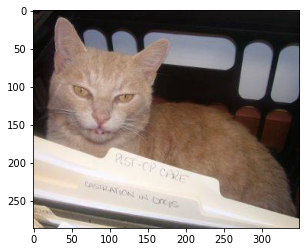

0.9819003939628601
I predict Cat


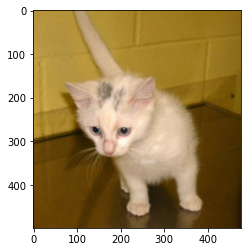

0.9613292217254639
I predict Cat


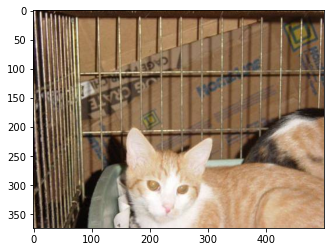

0.579064667224884
I predict Cat


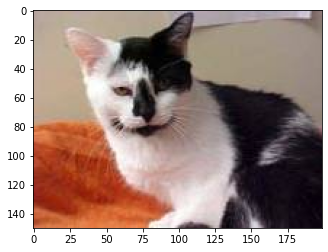

0.9841173887252808
I predict Cat


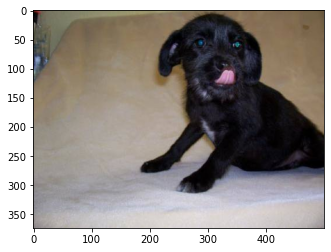

0.35533541440963745
I predict Dog


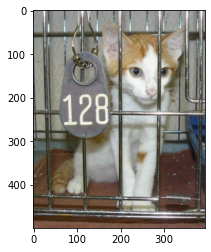

0.9421151280403137
I predict Cat


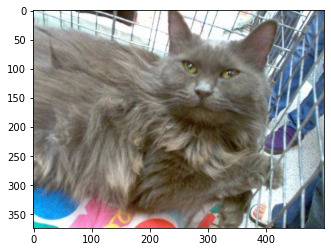

0.933769941329956
I predict Cat


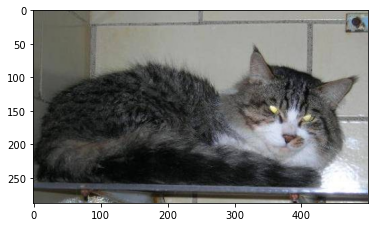

0.992466151714325
I predict Cat


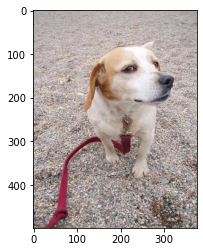

0.0008561270078644156
I predict Dog


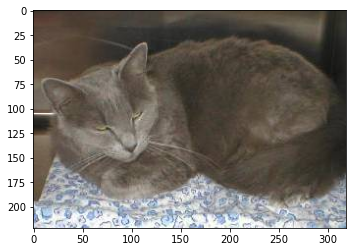

0.9836313724517822
I predict Cat


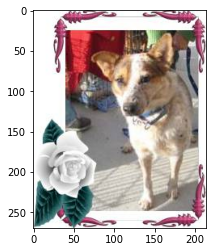

0.058696676045656204
I predict Dog


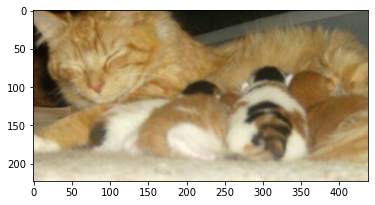

0.49678370356559753
I predict Dog


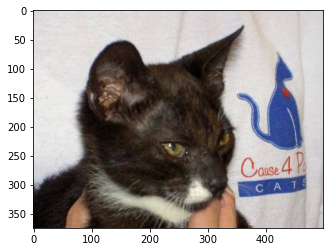

0.983964204788208
I predict Cat


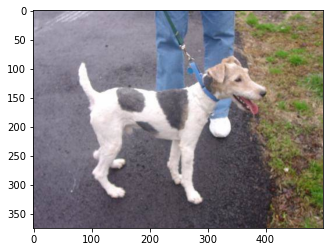

0.01773078367114067
I predict Dog


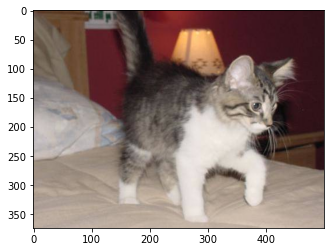

0.9931343793869019
I predict Cat


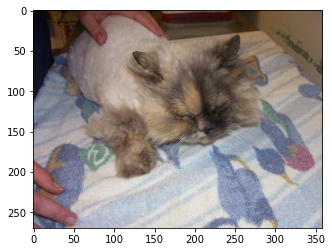

0.770081102848053
I predict Cat


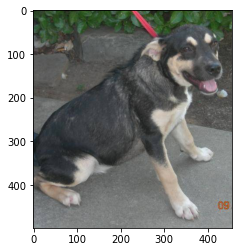

0.28876063227653503
I predict Dog


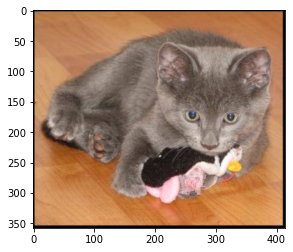

0.9917152523994446
I predict Cat


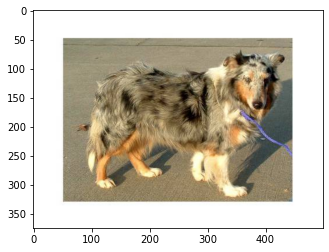

0.06189670413732529
I predict Dog


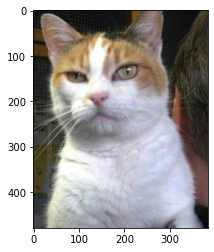

0.9816496968269348
I predict Cat


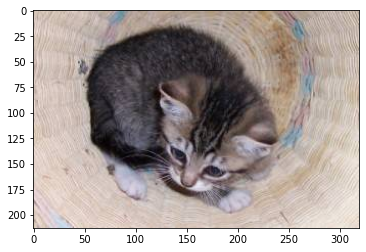

0.9526718258857727
I predict Cat


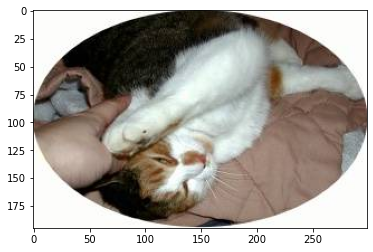

0.15189707279205322
I predict Dog


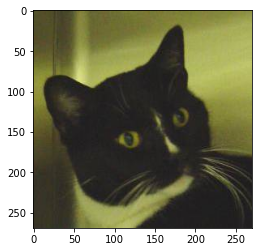

0.9950538873672485
I predict Cat


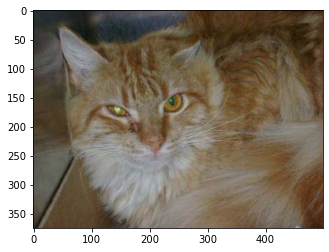

0.9869875907897949
I predict Cat


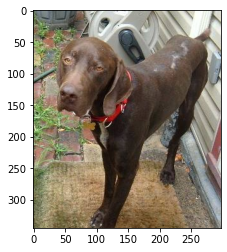

0.0023548163007944822
I predict Dog


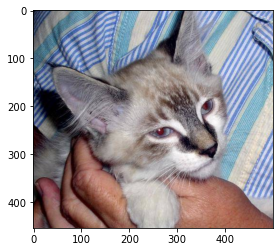

0.9749886393547058
I predict Cat


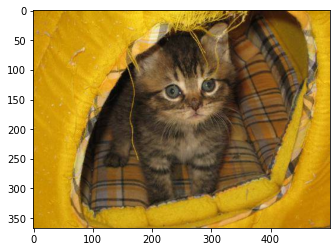

0.11680624634027481
I predict Dog


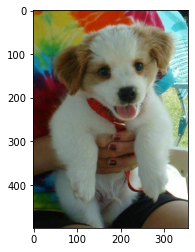

0.21358181536197662
I predict Dog


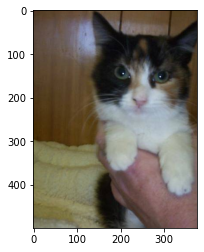

0.9484924077987671
I predict Cat


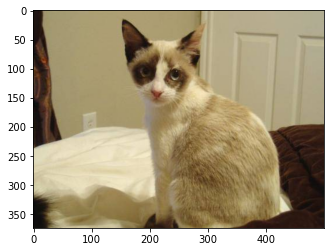

0.9041280746459961
I predict Cat


In [42]:
eval_dir(num_pics=30, model=best_model)